In [1]:
import json
import math
import os
import pickle
import random
from tqdm import tqdm

import anndata
import numpy as np
import pandas
import safetensors
import scanpy as sc
import scvi
import torch
from scvi.distributions import ZeroInflatedNegativeBinomial
from torch import nn
from torch.distributions import Normal
from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForCausalLM

import umap
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt

from utils.combo_split import combo_split_nochron

# Load pretrained model

In [2]:
model_dir = "/home/dfl32/scratch/training-runs/cinemaot-EleutherAI/pythia-160m-timepoints2-normoutTrue-ifm-2024-05-06_04-38-51"
cp_num = 5800
cp = f"checkpoint-{cp_num}"
cp_path = os.path.join(model_dir, cp)


device = torch.device("cuda")
tokenizer = AutoTokenizer.from_pretrained(cp_path)
model = AutoModelForCausalLM.from_pretrained(cp_path).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at /home/dfl32/scratch/training-runs/cinemaot-EleutherAI/pythia-160m-timepoints2-normoutTrue-ifm-2024-05-06_04-38-51/checkpoint-5800 were not used when initializing GPTNeoXForCausalLM: ['cell_enc.fc_layers.Layer 0.0.bias', 'cell_enc.fc_layers.Layer 0.0.weight', 'cell_enc.fc_layers.Layer 1.0.bias', 'cell_enc.fc_layers.Layer 1.0.weight', 'cell_enc.fc_layers.Layer 2.0.bias', 'cell_enc.fc_layers.Layer 2.0.weight', 'cell_proj_in.bias', 'cell_proj_in.weight', 'cell_proj_out.bias', 'cell_proj_out.weight', 'decoder.px_decoder.fc_layers.Layer 0.0.bias', 'decoder.px_decoder.fc_layers.Layer 0.0.weight', 'decoder.px_decoder.fc_layers.Layer 1.0.bias', 'decoder.px_decoder.fc_layers.Layer 1.0.weight', 'decoder.px_decoder.fc_layers.Layer 2.0.bias', 'decoder.px_decoder.fc_layers.Layer 2.0.weight', 'decoder.px_dropout_decoder.bias', 'decoder.px_dropou

In [3]:
adata_file_path = "/home/dfl32/project/ifm/cinemaot_data/hvg_normalized_cinemaot.h5ad"
scvi_checkpoint = "/home/dfl32/project/ifm/scvi_models/epoch99_layers3_latent30_hidden128model.pt"
adata = sc.read_h5ad(adata_file_path)

test_combos = combo_split_nochron()
adata.obs['cell_type_perturbation'] = list(zip(adata.obs['cell_type'], adata.obs['perturbation']))
train_adata = adata[~adata.obs['cell_type_perturbation'].isin(test_combos)].copy()
train_adata.obs.drop(columns=['cell_type_perturbation'], inplace=True)

scvi.model.SCVI.setup_anndata(train_adata)
scvi_model_cp_dir = "/".join(scvi_checkpoint.split("/")[:-1])
scvi_model_cp_prefix = scvi_checkpoint.split("/")[-1][:-8]
vae = scvi.model.SCVI.load(scvi_model_cp_dir, adata=train_adata, accelerator='gpu', prefix=scvi_model_cp_prefix)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     File /home/dfl32/project/ifm/scvi_models/epoch99_layers3_latent30_hidden128model.pt already downloaded    


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.11 /home/dfl32/.conda/envs/c2s2/lib/python3.11/site ...
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [16]:
model.cell_enc = vae.module.z_encoder.encoder.to(device)
model.cell_proj_in = nn.Linear(model.cell_enc.fc_layers[-1][0].out_features, model.config.hidden_size).to(device)
model.cell_proj_out = nn.Linear(model.config.hidden_size, model.cell_enc.fc_layers[-1][0].out_features).to(device)
model.output_norm = nn.LayerNorm(model.cell_enc.fc_layers[-1][0].out_features).to(device)
model.output_relu = nn.ReLU().to(device)
model.mean_encoder = vae.module.z_encoder.mean_encoder.to(device)
model.var_encoder = vae.module.z_encoder.var_encoder.to(device)
model.distribution = vae.module.z_encoder.distribution
model.var_eps = vae.module.z_encoder.var_eps
model.return_dist = vae.module.z_encoder.return_dist
model.z_transformation = vae.module.z_encoder.z_transformation
model.var_activation = vae.module.z_encoder.var_activation
model.px_r = vae.module.px_r.to(device)
model.decoder = vae.module.decoder.to(device)

In [17]:
model_weights_path = os.path.join(cp_path, "model.safetensors")
pt_state_dict = safetensors.torch.load_file(model_weights_path, device="cuda")

model.load_state_dict(pt_state_dict)
model.eval()

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 768)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-11): 12 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=768, out_features=2304, bias=True)
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=768, out_features=3072, bias=True)
          (dense_4h_to_h): Linear(in_features=3072, out_features=768, bias=True)
          

# Load and format data

In [7]:
train_ctr = train_adata[train_adata.obs['perturbation'] == 'No stimulation'].copy()

prompt_path = "/home/dfl32/project/ifm/prompts/cinemaot_prompts.json"

with open(prompt_path, 'r') as f:
    prompts = json.load(f)['prefix']

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Generate all combos

In [8]:
cell_types = list(train_adata.obs['cell_type'].unique())
perturbations = list(train_adata.obs['perturbation'].unique())

In [ ]:
# Get text prompts and their tokens

prompt_path = "/home/dfl32/project/ifm/prompts/cinemaot_prompts.json"

with open(prompt_path, 'r') as f:
    prompts = json.load(f)['prefix']

e2e = True # For save file names
time_points = 2
batch_size = 16


train_ctr = train_adata[train_adata.obs['perturbation'] == 'No stimulation'].copy()
# cell_types = ['B']
# perturbations = list(train_adata.obs['perturbation'].unique())

perturbed_cells_dict = {}
all_z_embs = {}
cell_paths_dict = {}
ctr_dict = {}
for cell_type in tqdm(cell_types):
    ctr_expr = train_ctr[train_ctr.obs['cell_type'] == cell_type].X
    for perturbation in perturbations:
        train_ctr = train_adata[train_adata.obs['perturbation'] == 'No stimulation'].copy()
        filtered_adata = train_adata[(train_adata.obs['cell_type'] == cell_type) & (train_adata.obs['perturbation'] == perturbation)]
        num_samples = len(filtered_adata)

        replace = False
        if num_samples > ctr_expr.shape[0]:
            replace = True
        indices = np.random.choice(ctr_expr.shape[0], num_samples, replace=replace)
        sampled_ctr_expr = ctr_expr[indices]

        print(f"CELL TYPE: {cell_type}, PERTURBATION: {perturbation} NUM SAMPLES: {num_samples}")
        key = (cell_type, perturbation)
        
        ctr_dict[key] = sampled_ctr_expr
        
        if num_samples > 0:
            batch_size = 16
            num_batches = math.ceil(num_samples/batch_size)
            
            cell_encs = []
            
            for batch_num in range(num_batches):
                input_exprs = sampled_ctr_expr[batch_num*batch_size:(batch_num+1)*batch_size]
                input_exprs = torch.tensor(input_exprs).to(device)
                cat_input = torch.tensor([0]*input_exprs.shape[0]).to(device)
                with torch.no_grad():
                    output_exprs = model.cell_enc(input_exprs, cat_input).to('cpu')
                cell_encs.append(output_exprs)
            cell_encs = torch.concat(cell_encs, axis=0)

            
            cell_expr = sampled_ctr_expr # For computing library size
            
            perturbed_cells = []

            prompts = [prompts[0].format(cell_type=cell_type, perturbation=perturbation)]*cell_encs.shape[0]
            tokens = tokenizer(prompts, return_tensors='pt')['input_ids']

            enc_embs = []
            combo_cell_paths = []
            with torch.no_grad():
                for batch_num in range(num_batches):
                    expr_tens = torch.tensor(cell_expr[batch_num*batch_size:(batch_num+1)*batch_size]).to(device)
                    library_size = torch.log(expr_tens.sum(1)).unsqueeze(1)
                    cell_paths = [expr_tens.cpu().unsqueeze(1).numpy()]
            
                    prefix_tens = tokens[batch_num*batch_size:(batch_num+1)*batch_size].to(device)
                    prefix_emb = model.gpt_neox.embed_in(prefix_tens)
            
                    cell_vae_embs = cell_encs[batch_num*batch_size:(batch_num+1)*batch_size].to(device)
                    cell_embs = model.cell_proj_in(cell_vae_embs).unsqueeze(1)
            
                    model_input = torch.concat([prefix_emb, cell_embs], axis=1)
                    
                    for time in range(time_points-1):
            
                        # Sample latent
                        model_output = model.gpt_neox(inputs_embeds=model_input)
                        model_output = model.cell_proj_out(model_output.last_hidden_state)
                        model_output = model.output_norm(model_output)
                        model_output = model.output_relu(model_output)
                        last_cell_embs = model_output[:, -1, :]
                        if time == time_points-2:
                            enc_embs.append(last_cell_embs.detach().cpu().numpy())
            
                        mean_embs = model.mean_encoder(last_cell_embs)
                        var_embs = model.var_encoder(last_cell_embs)
                            
                        var_embs = model.var_activation(var_embs) + model.var_eps
                        dist = Normal(mean_embs, var_embs.sqrt())
                        z_embs = dist.sample()
                        z_embs = model.z_transformation(z_embs)
                        # Decoding step
                        cat_list = torch.zeros(z_embs.shape[0], z_embs.shape[1]).to(device)
                        px_scale, px_r, px_rate, px_dropout = model.decoder(
                            'gene',
                            z_embs,
                            library_size,
                            cat_list
                        )
                        px_r = model.px_r
                        px_r = torch.exp(px_r)
                
                        px = ZeroInflatedNegativeBinomial(
                            mu=px_rate,
                            theta=px_r,
                            zi_logits=px_dropout,
                            scale=px_scale,
                        )
            
                        samples = px.sample()
                        cell_paths.append(samples.cpu().unsqueeze(1).numpy())
                        
                        # Get scvi embedding for next time step
                        next_cells = model.cell_enc(samples, cat_list)
                        next_cells = model.cell_proj_in(next_cells).unsqueeze(1)
                        model_input = torch.concat([model_input, next_cells], axis=1)
                    cell_paths = np.concatenate(cell_paths, axis=1)
                    combo_cell_paths.append(cell_paths)
                    perturbed_cells.append(samples.to('cpu').numpy())
                combo_cell_paths_np = np.concatenate(combo_cell_paths, axis=0)
                perturbed_cells_np = np.concatenate(perturbed_cells, axis=0)
                enc_embs_np = np.concatenate(enc_embs, axis=0)
                perturbed_cells_dict[key] = perturbed_cells_np
                all_z_embs[key] = enc_embs_np
                # cell_paths_dict[key] = combo_cell_paths_np
                
                data_dir = "/home/dfl32/project/ifm/data"
                save_fn = f"gen_paths_norm_cp{cp_num}_tp{time_points}_{cell_type}_{perturbation}.np"
                save_path = os.path.join(data_dir, save_fn)

                np.save(save_path, combo_cell_paths_np)
            
        

  0%|          | 0/7 [00:00<?, ?it/s]

CELL TYPE: B, PERTURBATION: IFN-III NUM SAMPLES: 361
CELL TYPE: B, PERTURBATION: IFNb + TNFa NUM SAMPLES: 460
CELL TYPE: B, PERTURBATION: IFNb NUM SAMPLES: 402
CELL TYPE: B, PERTURBATION: IL-6 NUM SAMPLES: 388
CELL TYPE: B, PERTURBATION: IFNb + IFNg NUM SAMPLES: 559
CELL TYPE: B, PERTURBATION: TNFa NUM SAMPLES: 201
CELL TYPE: B, PERTURBATION: IFNb + IL-6 NUM SAMPLES: 0
CELL TYPE: B, PERTURBATION: IFNg NUM SAMPLES: 0
CELL TYPE: B, PERTURBATION: No stimulation NUM SAMPLES: 413
CELL TYPE: B, PERTURBATION: IFNa2 NUM SAMPLES: 505


 14%|█▍        | 1/7 [00:04<00:28,  4.69s/it]

CELL TYPE: CD4 T, PERTURBATION: IFN-III NUM SAMPLES: 4630
CELL TYPE: CD4 T, PERTURBATION: IFNb + TNFa NUM SAMPLES: 5083
CELL TYPE: CD4 T, PERTURBATION: IFNb NUM SAMPLES: 4818
CELL TYPE: CD4 T, PERTURBATION: IL-6 NUM SAMPLES: 5566
CELL TYPE: CD4 T, PERTURBATION: IFNb + IFNg NUM SAMPLES: 4938
CELL TYPE: CD4 T, PERTURBATION: TNFa NUM SAMPLES: 0
CELL TYPE: CD4 T, PERTURBATION: IFNb + IL-6 NUM SAMPLES: 5460
CELL TYPE: CD4 T, PERTURBATION: IFNg NUM SAMPLES: 0
CELL TYPE: CD4 T, PERTURBATION: No stimulation NUM SAMPLES: 5375
CELL TYPE: CD4 T, PERTURBATION: IFNa2 NUM SAMPLES: 6504


 29%|██▊       | 2/7 [00:48<02:18, 27.61s/it]

CELL TYPE: NK, PERTURBATION: IFN-III NUM SAMPLES: 1496
CELL TYPE: NK, PERTURBATION: IFNb + TNFa NUM SAMPLES: 1448
CELL TYPE: NK, PERTURBATION: IFNb NUM SAMPLES: 1799
CELL TYPE: NK, PERTURBATION: IL-6 NUM SAMPLES: 1743
CELL TYPE: NK, PERTURBATION: IFNb + IFNg NUM SAMPLES: 0
CELL TYPE: NK, PERTURBATION: TNFa NUM SAMPLES: 1476
CELL TYPE: NK, PERTURBATION: IFNb + IL-6 NUM SAMPLES: 0
CELL TYPE: NK, PERTURBATION: IFNg NUM SAMPLES: 2409
CELL TYPE: NK, PERTURBATION: No stimulation NUM SAMPLES: 1740


 43%|████▎     | 3/7 [01:04<01:29, 22.25s/it]

CELL TYPE: CD8 T, PERTURBATION: IFN-III NUM SAMPLES: 1304
CELL TYPE: CD8 T, PERTURBATION: IFNb + TNFa NUM SAMPLES: 1295
CELL TYPE: CD8 T, PERTURBATION: IFNb NUM SAMPLES: 1386


In [22]:
data_dir = "/home/dfl32/project/ifm/data"
save_fn = f"gen_cells_norm_cp{cp_num}_tp{time_points}_e2e{e2e}.pickle"
save_path = os.path.join(data_dir, save_fn)

with open(save_path, "wb") as f:
    pickle.dump(perturbed_cells_dict, f)

In [23]:
data_dir = "/home/dfl32/project/ifm/data"
save_fn = f"gen_embs_norm_cp{cp_num}_tp{time_points}_e2e{e2e}.pickle"
save_path = os.path.join(data_dir, save_fn)

with open(save_path, "wb") as f:
    pickle.dump(all_z_embs, f)

In [24]:
data_dir = "/home/dfl32/project/ifm/data"
save_fn = f"ctr_cells_norm_cp{cp_num}_tp{time_points}_e2e{e2e}.pickle"
save_path = os.path.join(data_dir, save_fn)

with open(save_path, "wb") as f:
    pickle.dump(ctr_dict, f)

# Plots

In [26]:
adata_all_perts = train_adata[train_adata.obs['perturbation']!='No stimulation'].copy()
samples = vae.posterior_predictive_sample(adata=adata_all_perts)
gen = samples.todense()
gen_adata = anndata.AnnData(X=gen, obs=adata_all_perts.obs, var=adata_all_perts.var)

adata_all_perts.obs['sample'] = ['ground truth']*len(adata_all_perts)
gen_adata.obs['sample'] = ['scvi generated']*len(gen_adata)
all_adata = anndata.concat([adata_all_perts, gen_adata])
data = np.concatenate([adata_all_perts.X, gen], axis=0)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [27]:
e2e = True # For save file names
time_points = 2

data_dir = "/home/dfl32/project/ifm/data"
save_fn = f"gen_cells_norm_cp{cp_num}_tp{time_points}_e2e{e2e}.pickle"
save_path = os.path.join(data_dir, save_fn)

with open(save_path, "rb") as f:
    perturbed_cells_dict = pickle.load(f)

all_perts = [perturbed_cells_dict[key] for key in perturbed_cells_dict]
combo_labels = []
cell_type_labels = []
pert_labels = []
for key in perturbed_cells_dict:
    combo_labels += [key]*len(perturbed_cells_dict[key])
    cell_type_labels += [key[0]]*len(perturbed_cells_dict[key])
    pert_labels += [key[1]]*len(perturbed_cells_dict[key])
all_perts = np.concatenate(all_perts, axis=0)
ifm_norm_adata = anndata.AnnData(X=all_perts)
ifm_norm_adata.obs['cell_type'] = cell_type_labels
ifm_norm_adata.obs['perturbation'] = pert_labels
ifm_norm_adata.obs['sample'] = ['ifm']*len(ifm_norm_adata)
ifm_norm_adata = ifm_norm_adata[ifm_norm_adata.obs['perturbation'] != 'No stimulation'].copy()
simple_adata_all_perts = anndata.AnnData(X=adata_all_perts.X)
simple_adata_all_perts.obs['cell_type'] = list(adata_all_perts.obs['cell_type'])
simple_adata_all_perts.obs['perturbation'] = list(adata_all_perts.obs['perturbation'])
simple_adata_all_perts.obs['sample'] = ['train data']*len(simple_adata_all_perts)
combined_norm_adata = anndata.concat([simple_adata_all_perts, ifm_norm_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [28]:
combined_norm_adata

AnnData object with n_obs × n_vars = 132298 × 5000
    obs: 'cell_type', 'perturbation', 'sample'

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/

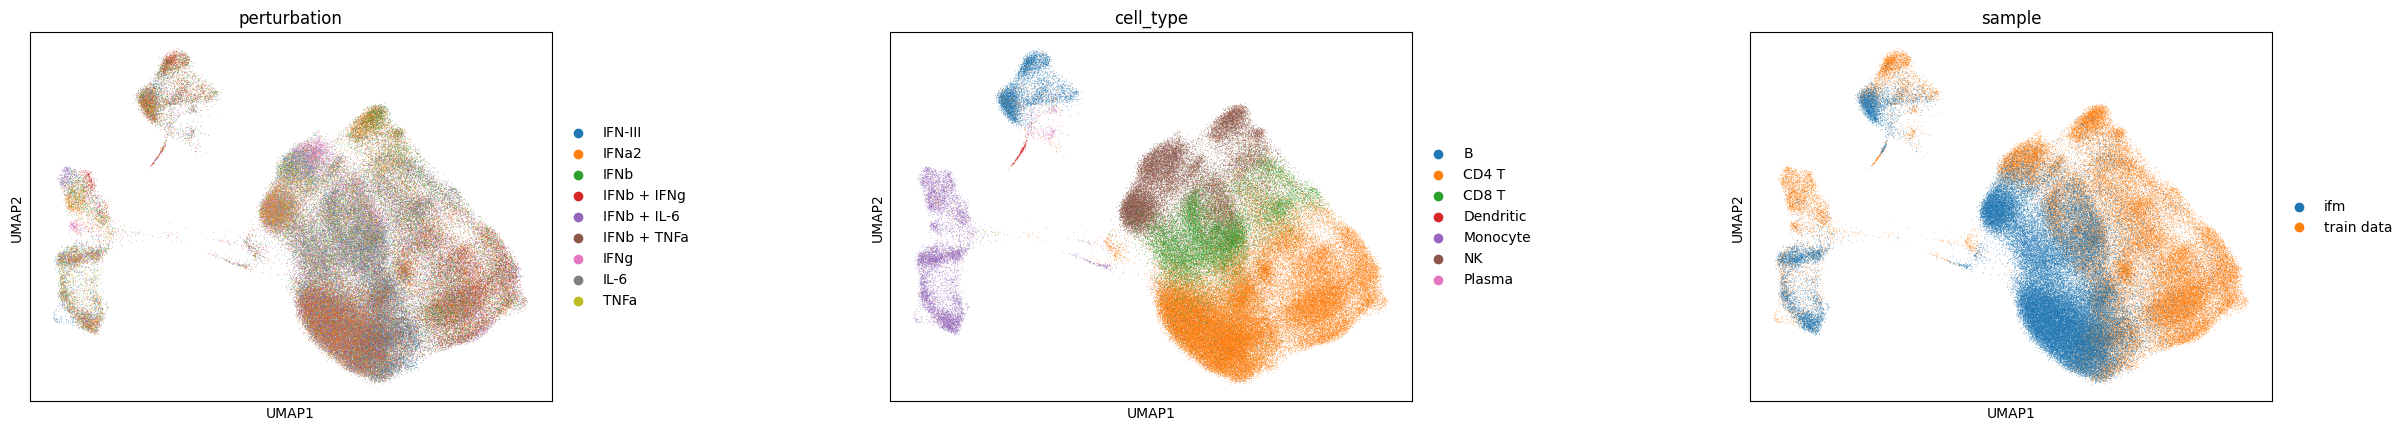

In [29]:
sc.pp.pca(combined_norm_adata)
sc.pp.neighbors(combined_norm_adata)
sc.tl.umap(combined_norm_adata)
sc.pl.umap(combined_norm_adata, color=['perturbation', 'cell_type', 'sample'], wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


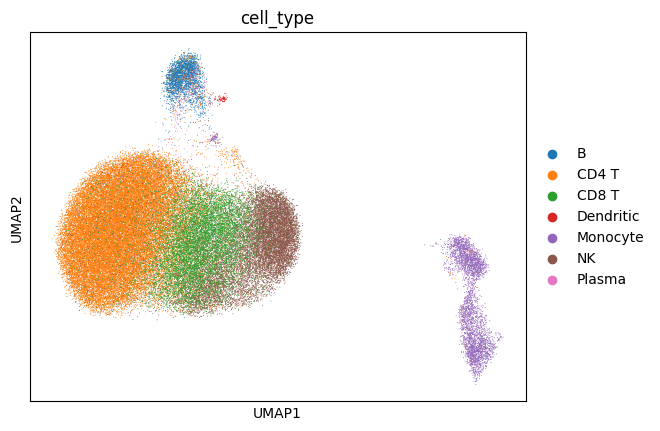

In [37]:
sc.pp.pca(ifm_norm_adata)
sc.pp.neighbors(ifm_norm_adata)
sc.tl.umap(ifm_norm_adata)
sc.pl.umap(ifm_norm_adata, color=['cell_type'], wspace=0.5, title="Generated Only")

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


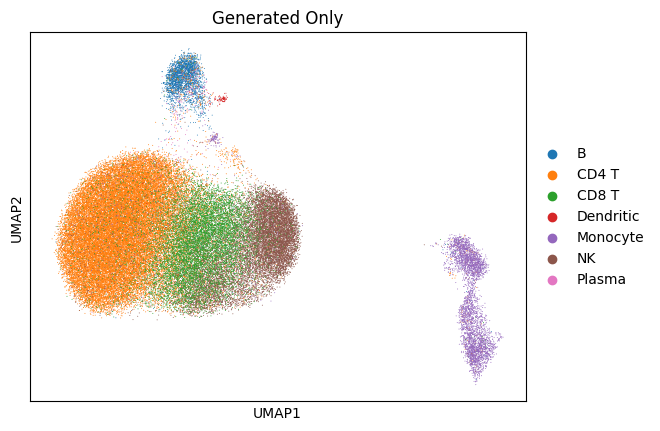

In [39]:
sc.pl.umap(ifm_norm_adata, color=['cell_type'], wspace=0.5, title="Generated Only")

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


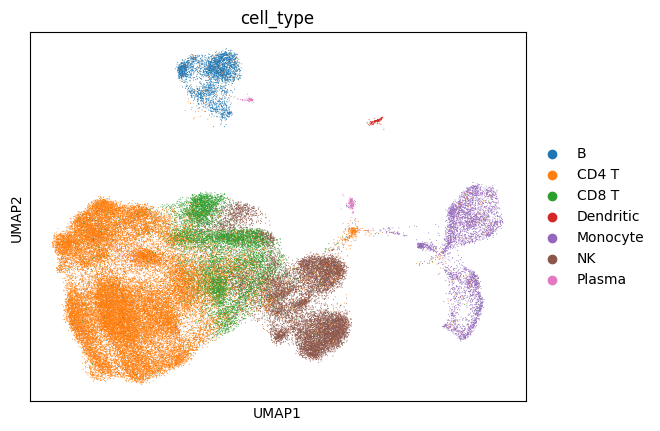

In [38]:
sc.pp.pca(simple_adata_all_perts)
sc.pp.neighbors(simple_adata_all_perts)
sc.tl.umap(simple_adata_all_perts)
sc.pl.umap(simple_adata_all_perts, color=['cell_type'], wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


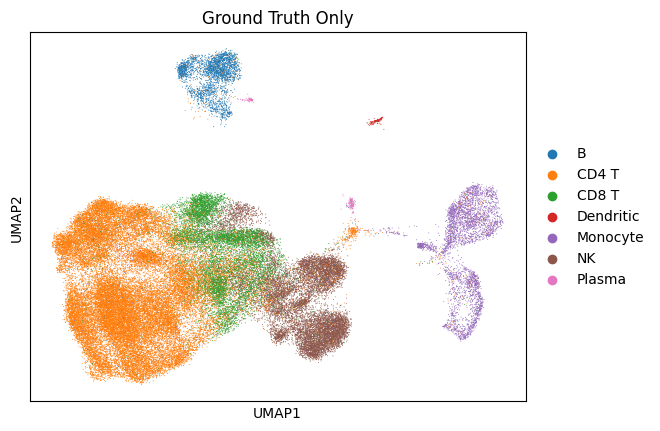

In [40]:
sc.pl.umap(simple_adata_all_perts, color=['cell_type'], wspace=0.5, title="Ground Truth Only")

In [34]:
expr_vecs = torch.tensor(adata_all_perts.X).to('cuda')
cat_input = torch.tensor([0]*expr_vecs.shape[0]).to('cuda')

z_embs = model.cell_enc(expr_vecs,cat_input)
z_embs = z_embs.detach().cpu().numpy()

In [35]:
data_dir = "/home/dfl32/project/ifm/data"
save_fn = f"gen_embs_norm_cp{cp_num}_tp{time_points}_e2e{e2e}.pickle"
save_path = os.path.join(data_dir, save_fn)

with open(save_path, "rb") as f:
    z_dict = pickle.load(f)

all_z_perts = [z_dict[key] for key in z_dict]
combo_labels = []
cell_type_labels = []
pert_labels = []
for key in z_dict:
    combo_labels += [key]*len(z_dict[key])
    cell_type_labels += [key[0]]*len(z_dict[key])
    pert_labels += [key[1]]*len(z_dict[key])
all_z_perts = np.concatenate(all_z_perts, axis=0)
ifm_norm_z_adata = anndata.AnnData(X=all_z_perts)
ifm_norm_z_adata.obs['cell_type'] = cell_type_labels
ifm_norm_z_adata.obs['perturbation'] = pert_labels
ifm_norm_z_adata.obs['sample'] = ['ifm']*len(ifm_norm_z_adata)
ifm_norm_z_adata = ifm_norm_z_adata[ifm_norm_z_adata.obs['perturbation'] != 'No stimulation'].copy()
simple_adata_all_z_perts = anndata.AnnData(X=z_embs)
simple_adata_all_z_perts.obs['cell_type'] = list(adata_all_perts.obs['cell_type'])
simple_adata_all_z_perts.obs['perturbation'] = list(adata_all_perts.obs['perturbation'])
simple_adata_all_z_perts.obs['sample'] = ['train data']*len(simple_adata_all_z_perts)
combined_norm_z_adata = anndata.concat([simple_adata_all_z_perts, ifm_norm_z_adata])

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py

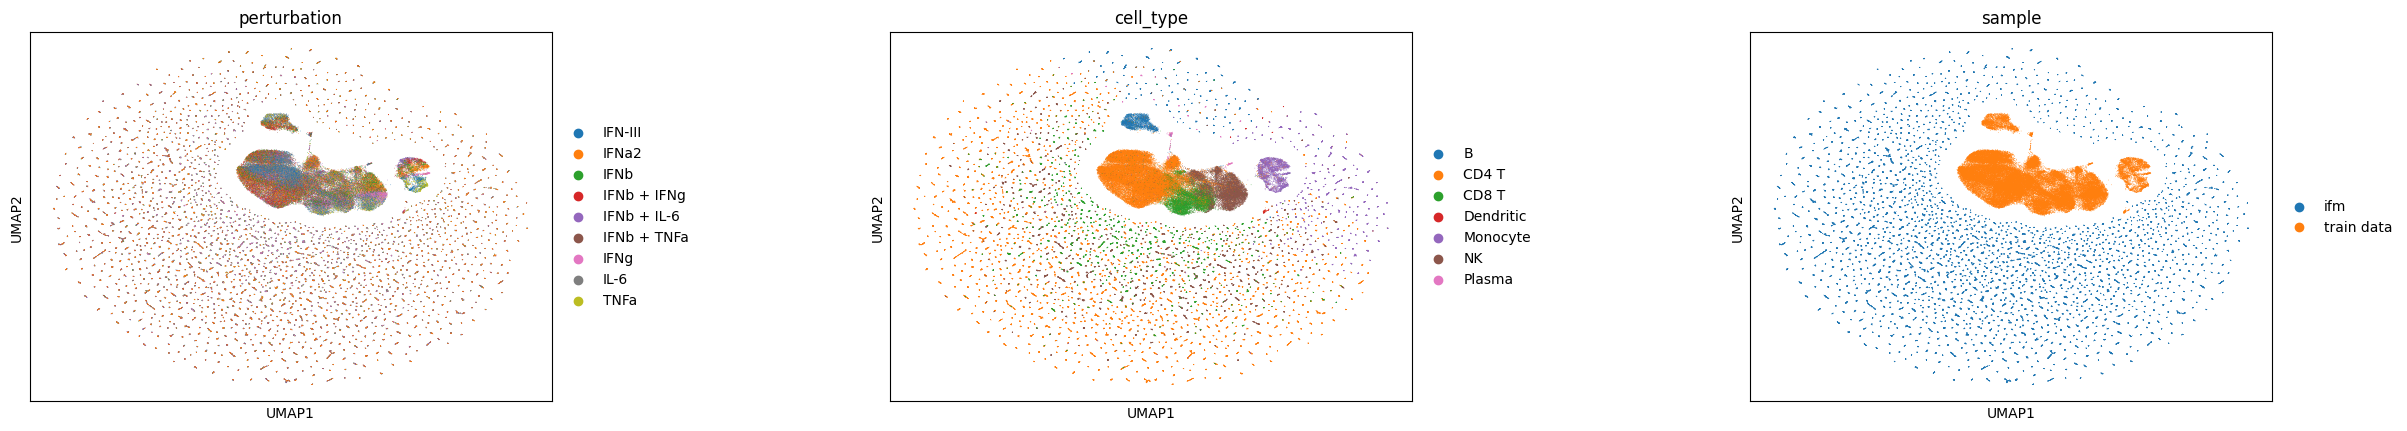

In [36]:
sc.pp.pca(combined_norm_z_adata)
sc.pp.neighbors(combined_norm_z_adata)
sc.tl.umap(combined_norm_z_adata)
sc.pl.umap(combined_norm_z_adata, color=['perturbation', 'cell_type', 'sample'], wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


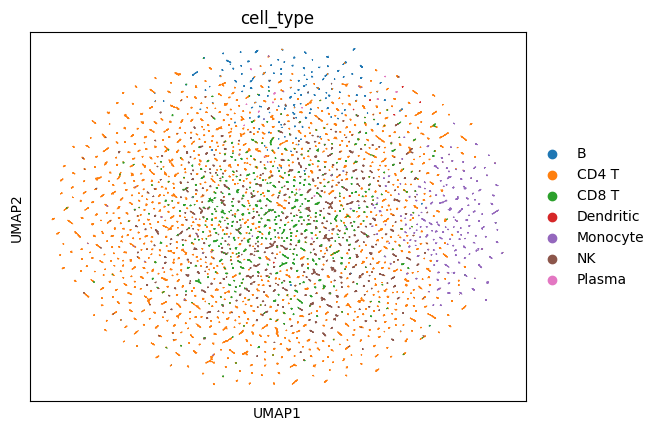

In [41]:
sc.pp.pca(ifm_norm_z_adata)
sc.pp.neighbors(ifm_norm_z_adata)
sc.tl.umap(ifm_norm_z_adata)
sc.pl.umap(ifm_norm_z_adata, color=['cell_type'], wspace=0.5)

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


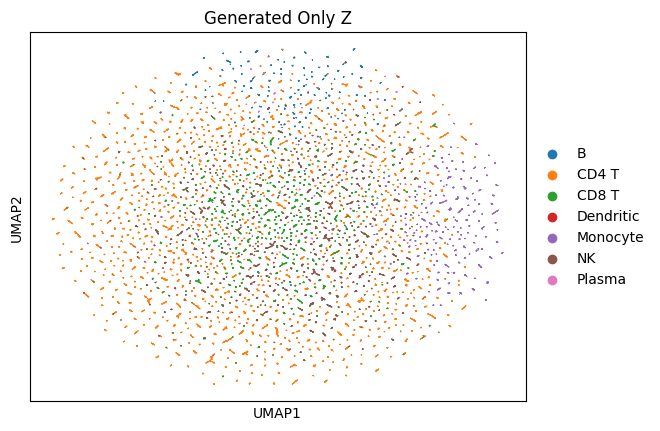

In [43]:
sc.pl.umap(ifm_norm_z_adata, color=['cell_type'], wspace=0.5, title="Generated Only Z")

/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/dfl32/.conda/envs/c2s2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


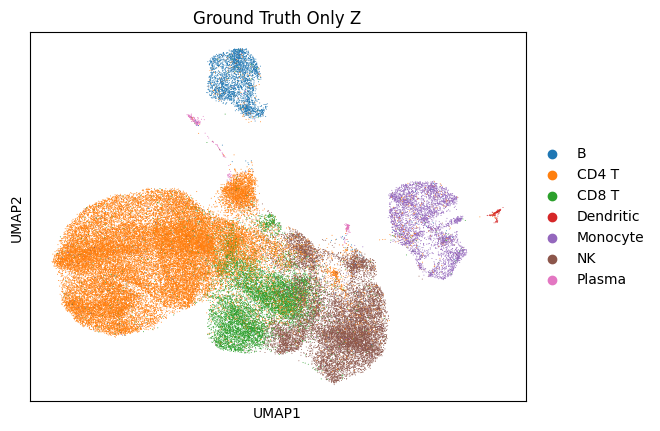

In [42]:
sc.pp.pca(simple_adata_all_z_perts)
sc.pp.neighbors(simple_adata_all_z_perts)
sc.tl.umap(simple_adata_all_z_perts)
sc.pl.umap(simple_adata_all_z_perts, color=['cell_type'], wspace=0.5, title="Ground Truth Only Z")